In [40]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

covid_df = pd.read_csv('multivariate_eng_df.csv', index_col = 'Date', parse_dates = True)

In [41]:
columns_to_drop_1 = ['Unnamed: 0']
covid_df = covid_df.drop(columns=columns_to_drop_1)
covid_df.rename(columns={'PEOPLE_DEATH_NEW_COUNT': 'people_new_death_count'}, inplace=True)

In [42]:
covid_df_top10.head()

,STATE,PROVINCE_STATE_NAME,Completeness_pct,Administered_Dose1_Recip,Administered_Dose1_Recip_5Plus,Administered_Dose1_Recip_12Plus,Administered_Dose1_Recip_18Plus,Administered_Dose1_Recip_65Plus,Series_Complete_Yes,Series_Complete_5Plus,...,vaccination_rate_complete,booster_rate,prop_age04,prop_age59,prop_age6064,prop_age8084,prop_age85plus,AGE04_29_TOT,AGE30_59_TOT,AGE60PLUS_TOT
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-01,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
2020-03-02,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
2020-03-03,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
2020-03-04,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
2020-03-05,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914


In [43]:
#dont want to predict with state name, also want to drop target column
columns_to_drop = ['PROVINCE_STATE_NAME', 'PEOPLE_POSITIVE_NEW_CASES_COUNT']
X = covid_df_Top10.drop(columns=columns_to_drop)

In [44]:
#separate target variable
y = covid_df_Top10['PEOPLE_POSITIVE_NEW_CASES_COUNT']

#train random forest model -- no train test split because just using for feature importance
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

RandomForestRegressor(random_state=42)

In [45]:
#extract feature importances
feature_importances = model.feature_importances_

#create a df to view the feature importances 
features_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)
features_df.head(15)

,Feature,Importance
130,new_cases_7_lag,0.628747
145,new_cases_10_std,0.093296
148,new_cases_10_max,0.081928
142,new_cases_10_mean,0.019885
162,new_deaths_100_max,0.011713
159,new_deaths_100_std,0.011385
134,new_cases_350_lag,0.010042
24,PEOPLE_DEATH_NEW_COUNT,0.009366
126,new_cases_1 lag,0.008986
108,new_hospitalized_patients,0.006298


## Feature Correlation Test

In [50]:
eng_feature_test = covid_df_Top10.loc[:, [
    'PEOPLE_POSITIVE_NEW_CASES_COUNT', 'vaccination_rate_complete', 'booster_rate', 'Vaccine_available',
'new_cases_1 lag', 'new_cases_4_lag', 
'new_cases_7_lag', 'new_cases_30_lag', 'new_cases_50_lag', 'new_cases_150_lag',
'new_cases_350_lag', 'new_deaths_1_lag', 
'new_deaths_4_lag', 'new_deaths_7_lag', 'new_deaths_30_lag', 'new_deaths_50_lag', 'prop_age04', 'prop_age59',
 'prop_age6064' ,'prop_age8084' ,'prop_age85plus', 'AGE04_29_TOT',
 'AGE30_59_TOT' ,'AGE60PLUS_TOT
]]

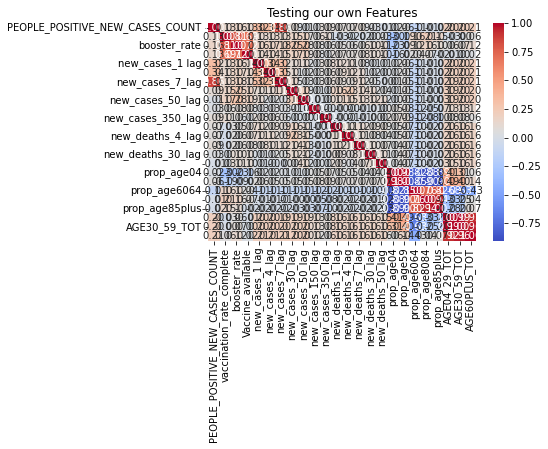

In [51]:
featue_test_matrix = eng_feature_test.corr()
sns.heatmap(featue_test_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Testing our own Features')
plt.show()

In [52]:
corr_threshold = 0.7

high_corr = set()
for i in range(len(featue_test_matrix.columns)):
    for j in range(i):
        if abs(featue_test_matrix.iloc[i, j]) > corr_threshold:
            colname = featue_test_matrix.columns[i]
            high_corr.add(colname)

In [53]:
high_corr

{'AGE30_59_TOT',
 'AGE60PLUS_TOT',
 'Vaccine_available',
 'booster_rate',
 'new_cases_7_lag',
 'prop_age59',
 'prop_age6064',
 'prop_age8084',
 'prop_age85plus'}